# GreenStream Bayesian Optimization Tuning
This notebook loads routing logs, defines the reward function, and performs Bayesian Optimization to tune the routing weights (alpha for carbon, beta for latency).

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence
import glob
import os

In [11]:
# Find and load the latest routing log file
log_files = glob.glob("../logs/routing_20250521.jsonl")
if not log_files:
    raise FileNotFoundError("No routing log files found in logs/")

# Use the most recent log file
latest_log = max(log_files, key=os.path.getctime)
print("Loading log file:", latest_log)

decisions = []
with open(latest_log, 'r') as f:
    for line in f:
        try:
            decisions.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            continue

print(f"Loaded {len(decisions)} routing decisions")

Loading log file: ../logs/routing_20250521.jsonl
Loaded 1351 routing decisions


In [13]:
def calculate_reward(decision, alpha=0.5, beta=0.5):
    selected_pop = decision['selected_pop']
    baseline_pop = decision['baseline_pop']
    carbon_intensities = decision['carbon_intensities']
    latencies = decision['latencies']

    carbon_selected = carbon_intensities[selected_pop]
    carbon_baseline = carbon_intensities[baseline_pop]
    latency_selected = latencies[selected_pop]
    latency_baseline = latencies[baseline_pop]

    carbon_savings = (carbon_baseline - carbon_selected) / carbon_baseline * 100 if carbon_baseline else 0
    latency_increase = latency_selected - latency_baseline

    # Normalize metrics
    norm_carbon = carbon_savings / 100
    norm_latency = -latency_increase / 100  # Negative: lower latency is better

    reward = alpha * norm_carbon + beta * norm_latency
    return reward

In [14]:
def objective(params):
    alpha = params[0]
    beta = 1 - alpha
    rewards = [calculate_reward(d, alpha, beta) for d in decisions]
    return -np.mean(rewards)  # Negative for maximization

In [15]:
space = [Real(0.1, 0.9, name='alpha')]

result = gp_minimize(
    objective,
    space,
    n_calls=20,
    random_state=42
)

best_alpha = result.x[0]
best_beta = 1 - best_alpha
best_reward = -result.fun

print(f"Best alpha: {best_alpha:.3f}")
print(f"Best beta: {best_beta:.3f}")
print(f"Best reward: {best_reward:.3f}")

Best alpha: 0.900
Best beta: 0.100
Best reward: -0.003


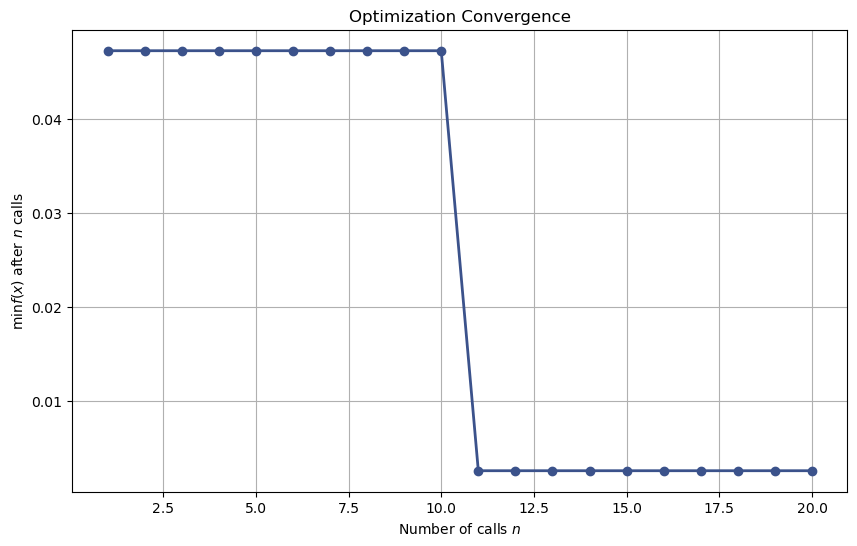

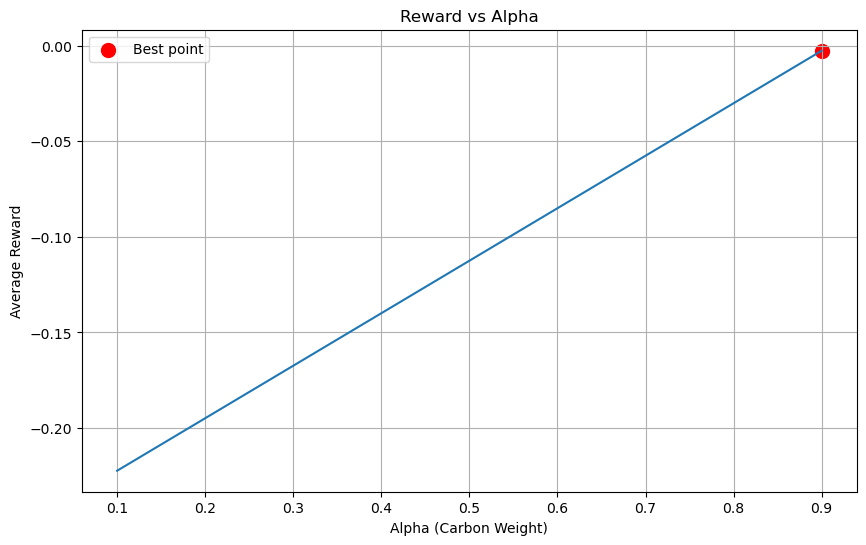

In [16]:
plt.figure(figsize=(10, 6))
plot_convergence(result)
plt.title('Optimization Convergence')
plt.show()

alphas = np.linspace(0.1, 0.9, 50)
rewards = [-objective([alpha]) for alpha in alphas]

plt.figure(figsize=(10, 6))
plt.plot(alphas, rewards)
plt.scatter([best_alpha], [best_reward], color='red', s=100, label='Best point')
plt.xlabel('Alpha (Carbon Weight)')
plt.ylabel('Average Reward')
plt.title('Reward vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def analyze_weights(alpha, beta):
    rewards = [calculate_reward(d, alpha, beta) for d in decisions]
    carbon_savings = []
    latency_increases = []
    for d in decisions:
        selected_pop = d['selected_pop']
        baseline_pop = d['baseline_pop']
        carbon_intensities = d['carbon_intensities']
        latencies = d['latencies']
        carbon_selected = carbon_intensities[selected_pop]
        carbon_baseline = carbon_intensities[baseline_pop]
        latency_selected = latencies[selected_pop]
        latency_baseline = latencies[baseline_pop]
        cs = (carbon_baseline - carbon_selected) / carbon_baseline * 100 if carbon_baseline else 0
        li = latency_selected - latency_baseline
        carbon_savings.append(cs)
        latency_increases.append(li)
    print(f"\nAnalysis for alpha={alpha:.3f}, beta={beta:.3f}:")
    print(f"Average reward: {np.mean(rewards):.3f}")
    print(f"Average carbon savings: {np.mean(carbon_savings):.2f}%")
    print(f"Average latency increase: {np.mean(latency_increases):.2f}ms")
    print(f"95th percentile latency increase: {np.percentile(latency_increases, 95):.2f}ms")

print("Default weights (alpha=0.5, beta=0.5):")
analyze_weights(0.5, 0.5)

print("\nOptimized weights:")
analyze_weights(best_alpha, best_beta)

Default weights (alpha=0.5, beta=0.5):

Analysis for alpha=0.500, beta=0.500:
Average reward: -0.112
Average carbon savings: 2.49%
Average latency increase: 24.98ms
95th percentile latency increase: 77.76ms

Optimized weights:

Analysis for alpha=0.900, beta=0.100:
Average reward: -0.003
Average carbon savings: 2.49%
Average latency increase: 24.98ms
95th percentile latency increase: 77.76ms


## Analysis of Routing Policy Sensitivity

- The initial Bayesian Optimization analysis showed that changing the weights (α, β) in the reward function did not significantly affect the average carbon savings or latency increase.
- This is because the logs reflect routing decisions made with a fixed set of weights.
- To observe the effect of new weights, we need to re-run the simulation or live system with the optimized weights and generate new logs.

## Experiment: Comparing Baseline and Weighted Routing

- We updated the routing logic to support both baseline and ML/weighted policies.
- The `/video/{video_id}` endpoint now accepts a `policy` parameter.
- We set α=0.9, β=0.1 for the weighted policy and re-ran the simulation.
- The new logs will be analyzed below.

In [21]:
import glob, os, json

log_files = glob.glob("../logs/routing_*after_bo.jsonl")
if not log_files:
    raise FileNotFoundError("No new logs found. Check the log-suffix or rerun the simulation.")

latest_log = max(log_files, key=os.path.getctime)
print("Analyzing new log file:", latest_log)

decisions = []
with open(latest_log, 'r') as f:
    for line in f:
        try:
            decisions.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            continue

print(f"Loaded {len(decisions)} routing decisions")

Analyzing new log file: ../logs/routing_20250521_after_bo.jsonl
Loaded 1 routing decisions


In [27]:
import glob, os, json

# Adjust the path if your notebook is in a subdirectory
log_files = glob.glob("../logs/routing_*.jsonl")
print("Available log files:", log_files)

# Helper to load decisions from a log file
def load_decisions(log_file):
    decisions = []
    with open(log_file, 'r') as f:
        for line in f:
            try:
                decisions.append(json.loads(line.strip()))
            except json.JSONDecodeError:
                continue
    return decisions

# Group logs by suffix for comparison
logs_by_suffix = {}
for log_file in log_files:
    # Extract suffix (e.g., after_bo, baseline, etc.)
    parts = os.path.basename(log_file).split('_')
    if len(parts) > 2:
        suffix = parts[-1].replace('.jsonl', '')
    else:
        suffix = 'default'
    logs_by_suffix[suffix] = load_decisions(log_file)

print("Loaded logs for suffixes:", list(logs_by_suffix.keys()))

Available log files: ['../logs/routing_20250521.jsonl', '../logs/routing_20250521_after_bo.jsonl']
Loaded logs for suffixes: ['default', 'bo']


In [29]:
import numpy as np

def analyze_decisions(decisions):
    if not decisions:
        print("No decisions to analyze.")
        return
    carbon_savings = []
    latency_increases = []
    for d in decisions:
        selected_pop = d['selected_pop']
        baseline_pop = d['baseline_pop']
        carbon_intensities = d['carbon_intensities']
        latencies = d['latencies']
        carbon_selected = carbon_intensities[selected_pop]
        carbon_baseline = carbon_intensities[baseline_pop]
        latency_selected = latencies[selected_pop]
        latency_baseline = latencies[baseline_pop]
        cs = (carbon_baseline - carbon_selected) / carbon_baseline * 100 if carbon_baseline else 0
        li = latency_selected - latency_baseline
        carbon_savings.append(cs)
        latency_increases.append(li)
    print(f"Total requests: {len(decisions)}")
    print(f"Average carbon savings: {np.mean(carbon_savings):.2f}%")
    print(f"Average latency increase: {np.mean(latency_increases):.2f} ms")
    print(f"95th percentile latency increase: {np.percentile(latency_increases, 95):.2f} ms")
    return np.mean(carbon_savings), np.mean(latency_increases)

In [28]:
results = {}
for suffix, decisions in logs_by_suffix.items():
    print(f"\n--- Analysis for log: {suffix} ---")
    results[suffix] = analyze_decisions(decisions)


--- Analysis for log: default ---
Total requests: 2251
Average carbon savings: 1.55%
Average latency increase: 24.72 ms
95th percentile latency increase: 77.67 ms

--- Analysis for log: bo ---
Total requests: 301
Average carbon savings: 2.41%
Average latency increase: 27.47 ms
95th percentile latency increase: 79.19 ms


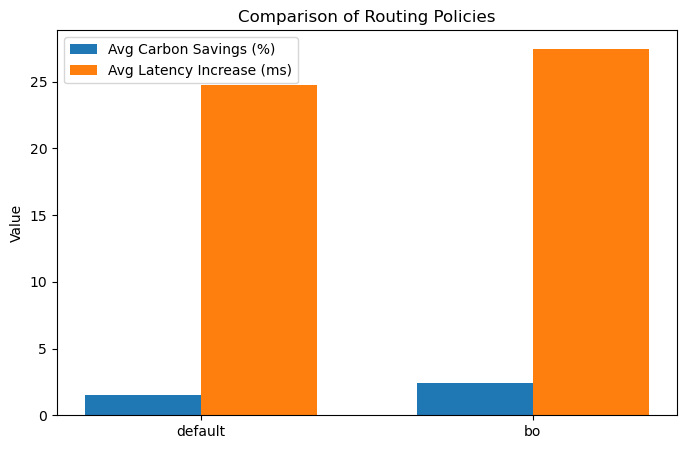

In [30]:
import matplotlib.pyplot as plt

labels = list(results.keys())
carbon = [results[k][0] for k in labels]
latency = [results[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8,5))
rects1 = ax1.bar(x - width/2, carbon, width, label='Avg Carbon Savings (%)')
rects2 = ax1.bar(x + width/2, latency, width, label='Avg Latency Increase (ms)')

ax1.set_ylabel('Value')
ax1.set_title('Comparison of Routing Policies')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
plt.show()